### Главна скрипта за примену ТоМАТо алгоритма на компоненте боје за сегментацију слике

In [1]:
%run imports.ipynb

Учитавамо слику са Лув компонентама боје и оцењујемо густину:

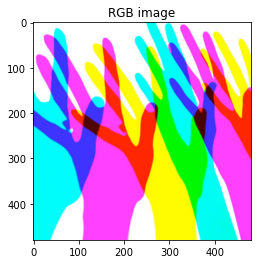

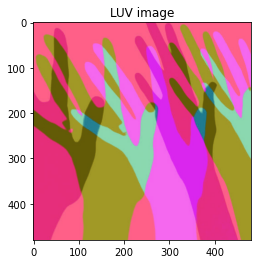

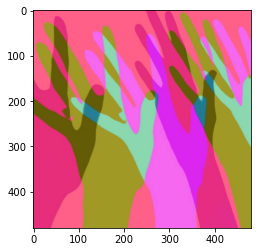

In [2]:
%matplotlib inline
%run ImageSegmentation.ipynb

In [3]:
x = np.vstack((l, u, v)).T
x.shape

(230400, 3)

In [4]:
x

array([[255,  96, 136],
       [255,  96, 136],
       [255,  96, 136],
       ...,
       [161, 153,  38],
       [161, 153,  38],
       [161, 153,  38]], dtype=uint8)

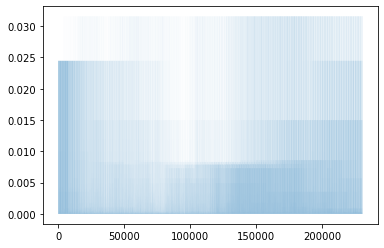

In [5]:
%run estimate_density2.ipynb

In [5]:
vec = pd.read_csv('C:/Users/vilda/Dropbox/TDA/TopoloskaAnalizaPodataka/PythonCodes/clustering/clustering_image/luv_dist/slika_ruke_gustina.csv')['0']

In [6]:
len(vec)

230400

In [ ]:
min(vec), max(vec)

Следећим делом кода смањујемо резолуцију слике, односно број тачака које улазе у тренинг скуп.

In [7]:
sparse = 3
sparse_matrix = np.asarray([[(j%sparse==0)&(i%sparse==0) for i in range(img_luv_new.shape[1])] for j in range(img_luv_new.shape[0])])

In [8]:
sparse_array = sparse_matrix.flatten()

In [11]:
kdt = KDTree(x, metric='euclidean')

In [12]:
from random import randrange
x_train = x[sparse_array]
x_train = np.asarray([list(x_train[randrange(x_train.shape[0])]) for i in np.arange(50000)])
x_train.shape

(50000, 3)

In [13]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(x_train, 'single')

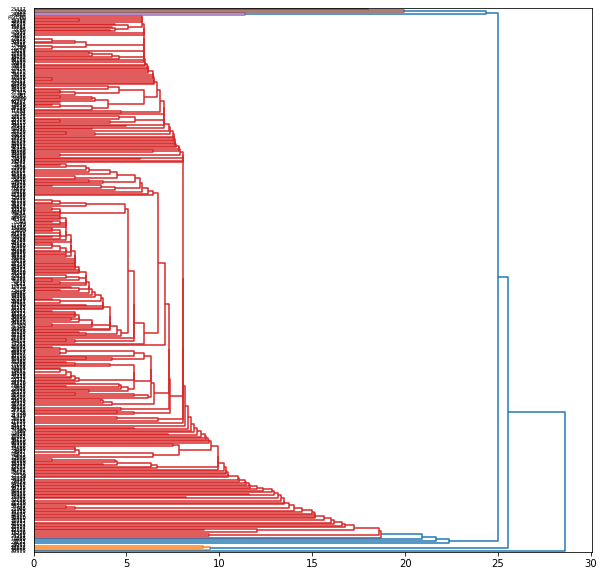

In [14]:
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, p=100,truncate_mode='level', orientation='right')

Бирамо Рипсов граф:

In [467]:
rads = np.linspace(0, 5, 10)
count_neis = [np.mean([kdt.query_radius([x_train[i]], rads[j], return_distance=False)[0].shape[0] for i in np.arange(x_train.shape[0])]) 
           for j in range(len(rads))]

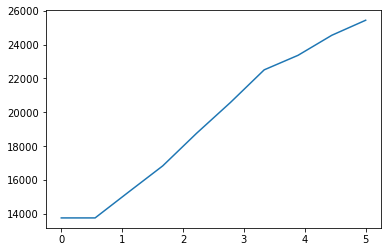

In [468]:
%matplotlib inline
plt.plot(rads, count_neis)
#plt.axvline(1.5)
#plt.axhline(50)

Бирамо граф к-најближих суседа:

In [215]:
neis = np.arange(100, 300, 20)
dist = [np.mean([kdt.query([x_train[i]], neis[j], return_distance=True)[0] for i in np.arange(x_train.shape[0])]) 
           for j in range(len(neis))]

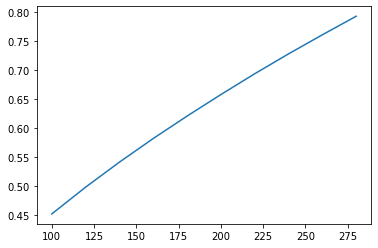

In [216]:
%matplotlib inline
plt.plot(neis, dist)

In [12]:
radius = 3

In [12]:
neighbours = 400

Правимо тренинг скуп и обележавамо тачке које су избачене:

In [13]:
group_matrix = np.asarray([[i+j*img_luv_new.shape[0] for i in np.arange(0, img_luv_new.shape[1], sparse) for _ in range(sparse)] 
                         for j in np.arange(0, img_luv_new.shape[0], sparse) for _ in range(sparse)]).flatten()

In [14]:
marked = np.asarray([-1 if sparse_array[i] else group_matrix[i] for i in range(x.shape[0])])

In [338]:
m=20

In [339]:
for ind in range(x.shape[0]):
    if (marked[ind] == -1):
        nei_drop = kdt.query_radius([x[ind]], radius/m, return_distance=False)[0]
        nei_drop = np.delete(nei_drop, np.where(nei_drop == ind))
        nei_drop = [elem for elem in nei_drop if marked[elem]==-1]
        marked[nei_drop] = ind

In [15]:
marked

array([    -1,      0,      0, ..., 229437, 229437, 229437])

In [16]:
np.sum(marked==-1)

25600

Иницијализовање и претпроцесирање података пре покретања алгоритма.

In [17]:
%run unionfind.ipynb
unf = UnionFind()

In [18]:
index_sorted = np.asarray([i for (e,i) in sorted([(e,i) for i,e in enumerate(vec)])])

In [19]:
vec_sorted = {i:e for (e,i) in sorted([(e,i) for i,e in enumerate(vec)])}
vec_sorted

{11415: 8.034402830195303e-07,
 11847: 8.034402830195303e-07,
 22860: 8.034402830195303e-07,
 23819: 8.034402830195303e-07,
 25592: 8.034402830195303e-07,
 25593: 8.034402830195303e-07,
 26073: 8.034402830195303e-07,
 26173: 8.034402830195303e-07,
 28618: 8.034402830195303e-07,
 30540: 8.034402830195303e-07,
 30608: 8.034402830195303e-07,
 31501: 8.034402830195303e-07,
 32064: 8.034402830195303e-07,
 33986: 8.034402830195303e-07,
 34636: 8.034402830195303e-07,
 37006: 8.034402830195303e-07,
 37999: 8.034402830195303e-07,
 42096: 8.034402830195303e-07,
 42902: 8.034402830195303e-07,
 44498: 8.034402830195303e-07,
 44916: 8.034402830195303e-07,
 45757: 8.034402830195303e-07,
 46237: 8.034402830195303e-07,
 46334: 8.034402830195303e-07,
 47801: 8.034402830195303e-07,
 47906: 8.034402830195303e-07,
 48281: 8.034402830195303e-07,
 48762: 8.034402830195303e-07,
 49217: 8.034402830195303e-07,
 49348: 8.034402830195303e-07,
 49828: 8.034402830195303e-07,
 50789: 8.034402830195303e-07,
 51750: 

Главна функција за имплементацију ТоМАТо алгоритма која враћа хијерархију кластера:

In [22]:
def define_clusters(vec_sorted, radius, tau):

    unf = UnionFind()
    n=len(vec)
    births = {}
    deaths = {}
    for i in reversed(range(n)):
        idx = index_sorted[i]
        if (marked[idx]==-1):
            nei = kdt.query_radius([x[idx]], radius, return_distance=False)[0]
            S = [elem for elem in nei if ((elem in index_sorted[(i+1):]) & (marked[elem]==-1))] 

            if not S:
                unf.insert_objects([idx]) 
                births[idx] = -vec_sorted[idx]
            else:
                parent = S[np.asarray([vec_sorted[j] for j in S]).argmax()]
                unf.union(parent, idx)
                roots = [unf.find(ele) for ele in S]
                highest = roots[np.asarray([vec_sorted[elem] for elem in roots]).argmax()]
                for root in roots:                   
                    if (root != parent) & (vec_sorted[root] - vec_sorted[idx] < tau):
                        unf.union(parent, root)
                        deaths[root] = -vec_sorted[idx]
                if (highest != parent) & (vec_sorted[parent] - vec_sorted[idx] < tau):
                    unf.union(highest, parent)
                    deaths[parent] = -vec_sorted[idx]
    return unf, births, deaths

In [23]:
unf, births, deaths = define_clusters(vec_sorted, radius=radius, tau=np.inf)

In [95]:
for idx in births.keys():
    if (idx not in deaths.keys()):
        deaths[idx] = np.inf

In [26]:
lifecycle = [(births[idx], deaths[idx]) for idx in births.keys()]

In [27]:
res = [(0, elem) for elem in lifecycle]
res

[(0, (-0.0315835807317506, -8.829647154160018e-07)),
 (0, (-0.024468229464825, -8.404378348950198e-07)),
 (0, (-0.0149919222018127, -8.172701051614804e-07)),
 (0, (-0.0085954898042098, -4.071762826004906e-06)),
 (0, (-0.0083033101662432, -8.107896290168296e-07)),
 (0, (-0.007989619383643, -9.21384081914718e-07)),
 (0, (-0.0078441433345651, -1.2346234124041156e-06)),
 (0, (-0.0035432018315482, -0.0011435565322513)),
 (0, (-0.0004418712682326, -1.3769796348950806e-06)),
 (0, (-0.0002750871057822, -0.0002025448078244)),
 (0, (-0.0002567945113641, -0.0002451224092942)),
 (0, (-0.000203205427637, -2.6478773925714093e-05)),
 (0, (-3.7553619626614935e-05, -2.0573810252793405e-05)),
 (0, (-3.5139879783317646e-05, -8.34666046784579e-06)),
 (0, (-2.5597533254467817e-05, -1.6324040187971266e-05)),
 (0, (-2.4628981810053165e-05, -1.5830270896541326e-05)),
 (0, (-2.450872974564428e-05, -4.999327648732945e-06)),
 (0, (-2.2678729212231372e-05, -2.233698769091193e-05)),
 (0, (-2.0320485905616536e-05, 

In [28]:
persistence = [elem[1]-elem[0] for elem in lifecycle]
sorted([elem for elem in persistence if ~np.isinf(elem)], reverse=True)

[0.03158269776703518,
 0.024467389026990104,
 0.01499110493170754,
 0.008591418041383796,
 0.008302499376614182,
 0.007988697999561084,
 0.007842908711152695,
 0.0023996452992968995,
 0.0004404942885977049,
 0.0001767266537112859,
 7.254229795779999e-05,
 2.6793219315471856e-05,
 1.9509402096911335e-05,
 1.7154283332914475e-05,
 1.697980937382153e-05,
 1.3608153696956491e-05,
 1.3080340166851854e-05,
 1.2326236048872069e-05,
 1.167210206990001e-05,
 1.1585352355173774e-05,
 1.1193701626323572e-05,
 1.1177348527643688e-05,
 1.1100132827811037e-05,
 1.0499041915462241e-05,
 1.0334515594432603e-05,
 1.0215800894295781e-05,
 9.794508144739388e-06,
 9.555808164202717e-06,
 9.29785260055218e-06,
 9.273493066496551e-06,
 9.223385959191483e-06,
 9.138786865769055e-06,
 8.905833921168932e-06,
 8.798710913511839e-06,
 8.777427688760545e-06,
 8.332206943460145e-06,
 8.034181569914299e-06,
 7.793302977348366e-06,
 7.649460538273611e-06,
 7.645404575452953e-06,
 7.591674855312077e-06,
 7.4324400084

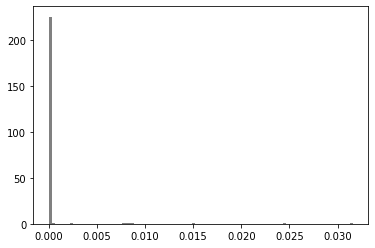

In [29]:
plt.hist([elem for elem in persistence if ~np.isinf(elem)], bins=100, color = 'gray')
plt.show()

<Figure size 1296x288 with 0 Axes>

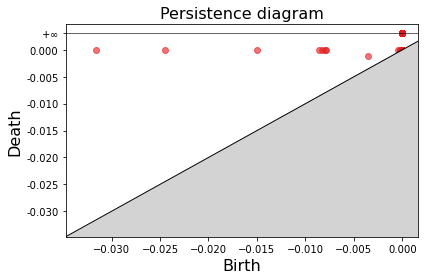

In [59]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gudhi.plot_persistence_diagram(res)
plt.tight_layout()
plt.show()

In [31]:
lifecycle_mod = [(-elem[0], 0) if elem[1]==np.inf else (-elem[0], -elem[1]) for elem in lifecycle]

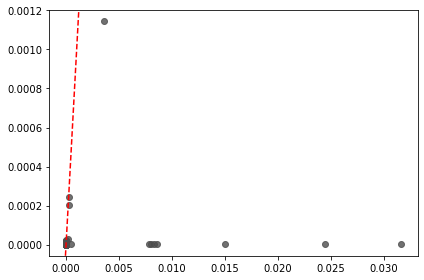

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter([elem[0] for elem in lifecycle_mod], [elem[1] for elem in lifecycle_mod], c=".3", alpha=0.8)
add_identity(ax, color='r', ls='--')
plt.tight_layout()
plt.show()

<Figure size 1296x288 with 0 Axes>

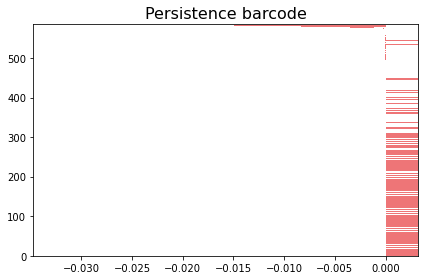

In [33]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gudhi.plot_persistence_barcode(res)
plt.tight_layout()
plt.show()

In [60]:
unf, births, deaths = define_clusters(vec_sorted, radius=radius, tau=0.002)

Број родитеља у хијерархији нам даје тачан број кластера и на основу њих правимо центроиде и одређујемо припадност сваке тачке добијеним кластерима.

In [62]:
len(np.unique(list(unf.parent_pointers.values())))

444

In [63]:
np.unique(list(unf.parent_pointers.values()))

array([    0,  4256,  7646,  9901, 10927, 12031, 13088, 19214, 22967,
       23066, 23254, 23272, 23296, 23339, 23347, 23365, 23372, 23378,
       23389, 23399, 23417, 23424, 23435, 23436, 23466, 23519, 23555,
       23586, 23592, 23601, 23633, 23637, 23638, 23689, 23709, 23712,
       23720, 23725, 23729, 23736, 23745, 23749, 23775, 23779, 23792,
       23820, 23824, 23842, 23845, 23878, 23897, 23899, 23916, 23933,
       23978, 23995, 24006, 24014, 24027, 24028, 24049, 24063, 24083,
       24090, 24107, 24123, 24133, 24164, 24169, 24171, 24223, 24240,
       24252, 24255, 24257, 24264, 24291, 24325, 24330, 24336, 24357,
       24398, 24400, 24405, 24416, 24443, 24446, 24448, 24512, 24532,
       24538, 24541, 24555, 24556, 24568, 24573, 24594, 24602, 24606,
       24607, 24623, 24633, 24635, 24639, 24644, 24661, 24693, 24696,
       24697, 24700, 24701, 24704, 24707, 24708, 24732, 24735, 24743,
       24746, 24750, 24759, 24774, 24777, 24784, 24786, 24788, 24797,
       24816, 24821,

In [64]:
cen, sts = [], []
ind = np.asarray(list(unf.num_to_objects.values()))
rts = np.asarray(list(unf.parent_pointers.values()))

In [65]:
for ele in np.unique(rts):

    cen.append(unf.num_to_objects[ele])
    sts.append(ind[np.where(rts == ele)[0]])

In [66]:
cen = np.asarray(cen)

In [67]:
cen

array([229437, 229221, 229311, 226119, 171471, 199074, 177363, 114135,
       222213, 141510,  60669, 141201, 182985, 162816, 134058,  53700,
       142644, 165699,  98028, 110949, 125370, 118347,  63660,  28953,
       188874,  37902, 102315,  23418, 104034,  37446,  39234, 190443,
        61977, 126816, 119721,  96894, 113931,  42027, 200520,  73884,
        47703,  99759,  31929, 115218,  96693, 108312, 113838, 105357,
       131268, 125544, 161658, 121065,  87894,  67941,  23172,  66651,
        46509,  96564,  90867, 104028, 174342, 155901,  89451, 102549,
       100911,  36171,  79464, 138318, 125514, 100998, 171462, 163098,
        90996,  67983,  78156, 155835, 193071,  14439,  36240,  57867,
        72282,  75147, 184662, 178665, 224751,  21867, 157218,  66429,
       112383,  46137,  66495,  86670, 102351, 121338, 144303, 128556,
        45033,  99576, 229410,  98274, 196062, 124104, 103953,  63768,
       168579, 102594, 115479,  37749,  89682,  49305,  83919,  37518,
      

In [68]:
sts

[array([229437, 229434, 229431, ...,  54738, 109548,  17655]),
 array([229221, 229218, 229215, ...,  10335, 184752,  53295]),
 array([229311, 229308, 229305, ...,  43356,  27624,  79356]),
 array([226116, 226113, 224679, ...,  82092,  70797,  15888]),
 array([171471, 171468, 171465, ..., 102318, 170034,  50442]),
 array([199074, 196194, 193314, ..., 125610, 206277,  78024]),
 array([177363, 173040, 171597, ..., 111039, 116820,  92526]),
 array([114135, 114132, 114129, 112695, 112692, 112689, 111255, 111252,
        111249, 109815, 109812, 109809, 108375, 108372, 108369, 106935,
        106932, 106929, 106926, 106923, 106920, 105495, 105492, 105489,
        105486, 105483, 105480, 104055, 104052, 104049, 104046, 104043,
        104040, 102615, 102612, 102609, 102606, 102603, 102600, 101175,
        101172, 101169, 101166, 101163, 101160,  99726,  99723,  99720,
         98286,  98283,  98280,  96846,  96843,  96840,  76710,  76707,
         76704,  75270,  75267,  75264,  73830,  73827,

In [69]:
threshold = 25
cluster_size = []
i=0
for elem in sts:
    if len(elem) > threshold:
        i=i+1
    print(len(elem))
    cluster_size.append(len(elem))
print('Broj klastera vecih od ', threshold,' je ',i)

5583
5472
3300
4586
1962
1523
1821
222
1
6
15
28
7
9
19
1
3
7
5
5
18
2
47
5
1
1
13
31
2
10
1
19
2
13
64
10
25
3
3
43
19
9
4
2
1
7
15
15
18
10
9
10
3
1
1
4
3
3
2
5
1
3
8
5
1
12
3
1
4
2
4
5
2
1
8
1
3
3
1
9
1
2
7
2
2
3
1
1
1
2
3
1
2
3
4
6
4
1
1
4
2
3
2
1
3
1
6
2
3
2
3
3
1
1
3
1
2
2
1
2
2
3
2
2
3
1
1
1
1
2
3
1
2
1
1
1
1
1
5
1
7
2
2
3
2
1
1
3
1
1
2
3
1
2
1
1
1
1
4
1
4
1
1
2
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
3
2
3
1
1
2
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
2
1
2
1
2
1
1
1
2
1
1
2
1
1
1
1
1
2
1
2
2
1
1
1
1
1
1
1
2
1
2
1
1
1
4
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Broj klastera vecih od  25  je  13


In [70]:
colors = []
def cluster_color(cen):
    for i in np.arange(len(cen)):
        if (cluster_size[i] > threshold):
            np.random.seed(i+123)
            colors.append(list(np.random.choice(range(256), size=3,)/255))
        else:
            colors.append([0,0,0])
    return colors
colors = cluster_color(cen)

In [71]:
idxs = []
for idx, grp in enumerate(sts):
    idxs = idxs + list(np.repeat(idx, len(sts[idx])))

In [72]:
grps = []
for idx, grp in enumerate(sts):
    grps = grps + list(grp)

In [74]:
cluster_dict = {k: v for k,v in zip(grps, idxs)}

In [76]:
idxs_all = idxs + [cluster_dict[elem] for idx,elem in enumerate(marked) if elem!=-1]
len(idxs_all)

230400

In [77]:
grps_all = grps + [idx for idx,elem in enumerate(marked) if elem!=-1]
len(grps_all)

230400

In [78]:
cluster_sort = sorted(zip(grps_all, idxs_all))

In [80]:
img_clustered = [[colors[elem[1]]] for elem in cluster_sort]

In [82]:
len(img_clustered)

230400

In [83]:
img_clustered_all = np.reshape(np.asarray(img_clustered), img_luv_new.shape)

In [84]:
img_clustered_all.shape

(480, 480, 3)

Финални резултат ТоМАТо алгоритма:

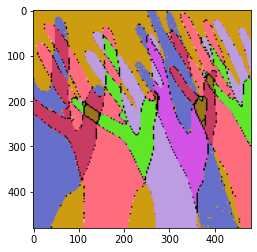

In [85]:
plt.imshow(img_clustered_all)

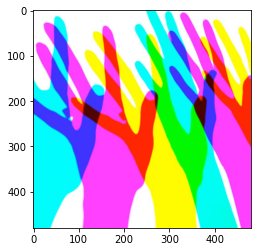

In [58]:
plt.imshow(img_rgb)